In [1]:
# general tools
import os
import sys
from glob import glob

# data tools
import re
import time
import h5py
import random
import numpy as np
from random import shuffle
from tensorflow import keras
from datetime import datetime, timedelta

2023-04-30 16:29:55.240135: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
#tf.config.run_functions_eagerly(True)

sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import model_utils as mu

In [18]:
import scipy.ndimage

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# import importlib
# importlib.reload(mu)

In [5]:
def verif_metric(VALID_target, Y_pred):
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    metric = BS
    return metric

In [6]:
# ==================== #
weights_round = 0
save_round = 1
seeds = 711 #777
model_prefix_load = 'RE3_smooth_base{}'.format(weights_round) #False
model_prefix_save = 'RE3_smooth_base{}'.format(save_round)
N_vars = L_vars = 15
lr = 1e-4
# ==================== #

In [7]:
# ----------------------------------------------------- #
# Collect pos and neg batch filenames
vers = ['v3', 'v4x', 'v4'] # HRRR v4, v4x, v4
leads = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

filenames_pos = {}
filenames_neg = {}

# Identify and separate pos / neg batch files
for ver in vers:
    for lead in leads:
        if ver == 'v3':
            path_ = path_batch_v3
        elif ver == 'v4':
            path_ = path_batch_v4
        else:
            path_ = path_batch_v4x
        
        filenames_pos['{}_lead{}'.format(ver, lead)] = sorted(glob("{}*pos*lead{}.npy".format(path_, lead)))
        filenames_neg['{}_lead{}'.format(ver, lead)] = sorted(glob("{}*neg_neg_neg*lead{}.npy".format(path_, lead)))
        
        print('{}, lead{}, pos: {}, neg: {}'.format(ver, lead, len(filenames_pos['{}_lead{}'.format(ver, lead)]), 
                                             len(filenames_neg['{}_lead{}'.format(ver, lead)])))



v3, lead2, pos: 6311, neg: 1130341
v3, lead3, pos: 4872, neg: 1131780
v3, lead4, pos: 3667, neg: 1132985
v3, lead5, pos: 2883, neg: 1135077
v3, lead6, pos: 2375, neg: 1134277
v3, lead7, pos: 1984, neg: 1134668
v3, lead8, pos: 1667, neg: 1136293
v3, lead9, pos: 1437, neg: 1136523
v3, lead10, pos: 1271, neg: 1136689
v3, lead11, pos: 1157, neg: 1136803
v3, lead12, pos: 1092, neg: 1136868
v3, lead13, pos: 1083, neg: 1135569
v3, lead14, pos: 1113, neg: 1135539
v3, lead15, pos: 1312, neg: 1135340
v3, lead16, pos: 1706, neg: 1136254
v3, lead17, pos: 2498, neg: 1135462
v3, lead18, pos: 3699, neg: 1134261
v3, lead19, pos: 5240, neg: 1132720
v3, lead20, pos: 6926, neg: 1129726
v3, lead21, pos: 8346, neg: 1129614
v3, lead22, pos: 9264, neg: 1128696
v3, lead23, pos: 9521, neg: 1128439
v4x, lead2, pos: 2294, neg: 443734
v4x, lead3, pos: 1849, neg: 445487
v4x, lead4, pos: 1400, neg: 445936
v4x, lead5, pos: 1108, neg: 446228
v4x, lead6, pos: 919, neg: 445109
v4x, lead7, pos: 773, neg: 443947
v4x, lea

In [8]:
np.save(save_dir_campaign+'HRRR_filenames_pos.npy', filenames_pos)
np.save(save_dir_campaign+'HRRR_filenames_neg.npy', filenames_neg)

In [9]:
filenames_pos = np.load(save_dir_campaign+'HRRR_filenames_pos.npy', allow_pickle=True)[()]
filenames_neg = np.load(save_dir_campaign+'HRRR_filenames_neg.npy', allow_pickle=True)[()]

In [10]:
# ----------------------------------------------------- #
# Separate train and valid from pos / neg batches
filenames_pos_train = {}
filenames_neg_train = {}

filenames_pos_valid = {}
filenames_neg_valid = {}

for ver in vers:
    for lead in leads:
        temp_namelist_pos = filenames_pos['{}_lead{}'.format(ver, lead)]
        temp_namelist_neg = filenames_neg['{}_lead{}'.format(ver, lead)]
        
        pos_train, pos_valid = mu.name_extract(temp_namelist_pos)
        neg_train, neg_valid = mu.name_extract(temp_namelist_neg)
        
        print('pos train: {} pos valid: {} neg train: {} neg valid {}'.format(len(pos_train), len(pos_valid), len(neg_train),len(neg_valid)))
        
        filenames_pos_train['{}_lead{}'.format(ver, lead)] = pos_train
        filenames_neg_train['{}_lead{}'.format(ver, lead)] = neg_train
        filenames_pos_valid['{}_lead{}'.format(ver, lead)] = pos_valid
        filenames_neg_valid['{}_lead{}'.format(ver, lead)] = neg_valid

pos train: 5515 pos valid: 796 neg train: 945401 neg valid 184940
pos train: 4265 pos valid: 607 neg train: 946651 neg valid 185129
pos train: 3229 pos valid: 438 neg train: 947687 neg valid 185298
pos train: 2556 pos valid: 327 neg train: 949668 neg valid 185409
pos train: 2100 pos valid: 275 neg train: 948816 neg valid 185461
pos train: 1747 pos valid: 237 neg train: 949169 neg valid 185499
pos train: 1457 pos valid: 210 neg train: 950767 neg valid 185526
pos train: 1245 pos valid: 192 neg train: 950979 neg valid 185544
pos train: 1116 pos valid: 155 neg train: 951108 neg valid 185581
pos train: 1023 pos valid: 134 neg train: 951201 neg valid 185602
pos train: 962 pos valid: 130 neg train: 951262 neg valid 185606
pos train: 954 pos valid: 129 neg train: 949962 neg valid 185607
pos train: 980 pos valid: 133 neg train: 949936 neg valid 185603
pos train: 1149 pos valid: 163 neg train: 949767 neg valid 185573
pos train: 1476 pos valid: 230 neg train: 950748 neg valid 185506
pos train: 21

In [11]:
np.save(save_dir_campaign+'HRRR_filenames_pos_train.npy', filenames_pos_train)
np.save(save_dir_campaign+'HRRR_filenames_neg_train.npy', filenames_neg_train)

In [12]:
filenames_pos_train = np.load(save_dir_campaign+'HRRR_filenames_pos_train.npy', allow_pickle=True)[()]
filenames_neg_train = np.load(save_dir_campaign+'HRRR_filenames_neg_train.npy', allow_pickle=True)[()]

In [14]:
# ------------------------------------------------------------------ #
# Merge train/valid and pos/neg batch files from multiple lead times
pos_train_all = []
neg_train_all = []

for ver in vers:
    for lead in leads:
        pos_train_all += filenames_pos_train['{}_lead{}'.format(ver, lead)]
        neg_train_all += filenames_neg_train['{}_lead{}'.format(ver, lead)]
        
pos_train_v3 = []
neg_train_v3 = []

pos_train_v4x = []
neg_train_v4x = []

pos_train_v4 = []
neg_train_v4 = []

for lead in leads:
    pos_train_v3 += filenames_pos_train['{}_lead{}'.format('v3', lead)]
    neg_train_v3 += filenames_neg_train['{}_lead{}'.format('v3', lead)]
    
    pos_train_v4x += filenames_pos_train['{}_lead{}'.format('v4x', lead)]
    neg_train_v4x += filenames_neg_train['{}_lead{}'.format('v4x', lead)]
    
    pos_train_v4 += filenames_pos_train['{}_lead{}'.format('v4', lead)]
    neg_train_v4 += filenames_neg_train['{}_lead{}'.format('v4', lead)]

In [16]:
def neighbour_leads(lead):
    out = [lead-2, lead-1, lead, lead+1]
    flag_shift = [0, 0, 0, 0]
    
    for i in range(4):
        if out[i] < 0:
            out[i] = 24+out[i]
            flag_shift[i] = -1
        if out[i] > 23:
            out[i] = out[i]-24
            flag_shift[i] = +1
            
    return out, flag_shift


def filename_to_loc(filenames):
    lead_out = []
    indx_out = []
    indy_out = []
    day_out = []
    
    for i, name in enumerate(filenames):
        
        nums = re.findall(r'\d+', name)
        
        lead = int(nums[-1])
        indy = int(nums[-2])
        indx = int(nums[-3])
        day = int(nums[-4])
      
        indx_out.append(indx)
        indy_out.append(indy)
        day_out.append(day)
        lead_out.append(lead)
        
    return np.array(indx_out), np.array(indy_out), np.array(day_out), np.array(lead_out)


In [17]:
label_smooth_v3 = ()
label_smooth_v4x = ()
label_smooth_v4 = ()

for lead in leads:

    lead_window, flag_shift = neighbour_leads(lead)
    
    print('Collect HRRR v3 labels ...')
    
    record_all = ()

    for i, lead_temp in enumerate(lead_window):

        flag_ = flag_shift[i]

        with h5py.File(save_dir_scratch+'SPC_to_lead{}_72km_all.hdf'.format(lead_temp), 'r') as h5io:
            record_temp = h5io['record_v3'][...]

        if flag_shift[i] == 0:
            record_all = record_all + (record_temp,)

        if flag_shift[i] == -1:
            record_temp[1:, ...] = record_temp[:-1, ...]
            record_temp[0, ...] = np.nan
            record_all = record_all + (record_temp,)

        if flag_shift[i] == +1:
            record_temp[:-1, ...] = record_temp[1:, ...]
            record_temp[-1, ...] = np.nan
            record_all = record_all + (record_temp,)


    shape_record = record_temp.shape      
    record_v3 = np.empty(shape_record)
    record_v3[...] = 0.0 #np.nan

    for i in range(4):
        record_temp = record_all[i]
        for day in range(shape_record[0]):
            for ix in range(shape_record[1]):
                for iy in range(shape_record[2]):
                    for event in range(shape_record[3]):
                        if record_temp[day, ix, iy, event] > 0:
                            record_v3[day, ix, iy, event] = 1.0
                        elif record_v3[day, ix, iy, event] == 1.0:
                            record_v3[day, ix, iy, event] = 1.0
                        else:
                            record_v3[day, ix, iy, event] = 0.0
    
    label_smooth_v3 += (record_v3[None, ...],)
    
    print('Collect HRRR v4x labels ...')
    
    record_all = ()

    for i, lead_temp in enumerate(lead_window):

        flag_ = flag_shift[i]

        with h5py.File(save_dir_scratch+'SPC_to_lead{}_72km_v4x.hdf'.format(lead_temp), 'r') as h5io:
            record_temp = h5io['record_v4x'][...]

        if flag_shift[i] == 0:
            record_all = record_all + (record_temp,)

        if flag_shift[i] == -1:
            record_temp[1:, ...] = record_temp[:-1, ...]
            record_temp[0, ...] = np.nan
            record_all = record_all + (record_temp,)

        if flag_shift[i] == +1:
            record_temp[:-1, ...] = record_temp[1:, ...]
            record_temp[-1, ...] = np.nan
            record_all = record_all + (record_temp,)


    shape_record = record_temp.shape      
    record_v4x = np.empty(shape_record)
    record_v4x[...] = np.nan

    for i in range(4):
        record_temp = record_all[i]
        for day in range(shape_record[0]):
            for ix in range(shape_record[1]):
                for iy in range(shape_record[2]):
                    for event in range(shape_record[3]):
                        if record_temp[day, ix, iy, event] > 0:
                            record_v4x[day, ix, iy, event] = 1.0
                        elif record_v4x[day, ix, iy, event] == 1.0:
                            record_v4x[day, ix, iy, event] = 1.0
                        else:
                            record_v4x[day, ix, iy, event] = 0.0
    
    label_smooth_v4x += (record_v4x[None, ...],)
    
    print('Collect HRRR v4 labels ...')
    
    record_all = ()
    
    for i, lead_temp in enumerate(lead_window):

        flag_ = flag_shift[i]

        with h5py.File(save_dir_scratch+'SPC_to_lead{}_72km_all.hdf'.format(lead_temp), 'r') as h5io:
            record_temp = h5io['record_v4'][...]

        if flag_shift[i] == 0:
            record_all = record_all + (record_temp,)

        if flag_shift[i] == -1:
            record_temp[1:, ...] = record_temp[:-1, ...]
            record_temp[0, ...] = np.nan
            record_all = record_all + (record_temp,)

        if flag_shift[i] == +1:
            record_temp[:-1, ...] = record_temp[1:, ...]
            record_temp[-1, ...] = np.nan
            record_all = record_all + (record_temp,)
            
            
    shape_record = record_temp.shape      
    record_v4 = np.empty(shape_record)
    record_v4[...] = 0.0 #np.nan

    for i in range(4):
        record_temp = record_all[i]
        for day in range(shape_record[0]):
            for ix in range(shape_record[1]):
                for iy in range(shape_record[2]):
                    for event in range(shape_record[3]):
                        if record_temp[day, ix, iy, event] > 0:
                            record_v4[day, ix, iy, event] = 1.0
                        elif record_v4[day, ix, iy, event] == 1.0:
                            record_v4[day, ix, iy, event] = 1.0
                        else:
                            record_v4[day, ix, iy, event] = 0.0
                            
    label_smooth_v4 += (record_v4[None, ...],)
    
    print('... Done')
    


Collect HRRR v3 labels ...
Collect HRRR v4x labels ...
Collect HRRR v4 labels ...
... Done
Collect HRRR v3 labels ...
Collect HRRR v4x labels ...
Collect HRRR v4 labels ...
... Done
Collect HRRR v3 labels ...
Collect HRRR v4x labels ...
Collect HRRR v4 labels ...
... Done
Collect HRRR v3 labels ...
Collect HRRR v4x labels ...
Collect HRRR v4 labels ...
... Done
Collect HRRR v3 labels ...
Collect HRRR v4x labels ...
Collect HRRR v4 labels ...
... Done
Collect HRRR v3 labels ...
Collect HRRR v4x labels ...
Collect HRRR v4 labels ...
... Done
Collect HRRR v3 labels ...
Collect HRRR v4x labels ...
Collect HRRR v4 labels ...
... Done
Collect HRRR v3 labels ...
Collect HRRR v4x labels ...
Collect HRRR v4 labels ...
... Done
Collect HRRR v3 labels ...
Collect HRRR v4x labels ...
Collect HRRR v4 labels ...
... Done
Collect HRRR v3 labels ...
Collect HRRR v4x labels ...
Collect HRRR v4 labels ...
... Done
Collect HRRR v3 labels ...
Collect HRRR v4x labels ...
Collect HRRR v4 labels ...
... Done

NameError: name 'scipy' is not defined

In [19]:
label_concat_v3 = np.concatenate(label_smooth_v3, axis=0)
label_concat_v4x = np.concatenate(label_smooth_v4x, axis=0)
label_concat_v4 = np.concatenate(label_smooth_v4, axis=0)

label_concat_v3 = np.sum(label_concat_v3, axis=-1)
label_concat_v3[label_concat_v3>1] = 1

label_concat_v4 = np.sum(label_concat_v4, axis=-1)
label_concat_v4[label_concat_v4>1] = 1

label_concat_v4x = np.sum(label_concat_v4x, axis=-1)
label_concat_v4x[label_concat_v4x>1] = 1

shape_label_v3 = label_concat_v3.shape
shape_label_v4 = label_concat_v4.shape
shape_label_v4x = label_concat_v4x.shape

label_final_v3 = np.empty(shape_label_v3)
label_final_v4 = np.empty(shape_label_v4)
label_final_v4x = np.empty(shape_label_v4x)

for i in range(shape_label_v3[0]):
    for j in range(shape_label_v3[1]):
        label_final_v3[i, j, ...] = scipy.ndimage.gaussian_filter(label_concat_v3[i, j], sigma=2.5)
        
for i in range(shape_label_v4[0]):
    for j in range(shape_label_v4[1]):
        label_final_v4[i, j, ...] = scipy.ndimage.gaussian_filter(label_concat_v4[i, j], sigma=2.5)
        
for i in range(shape_label_v4x[0]):
    for j in range(shape_label_v4x[1]):
        label_final_v4x[i, j, ...] = scipy.ndimage.gaussian_filter(label_concat_v4x[i, j], sigma=2.5)
        
indx_pos_train_v3, indy_pos_train_v3, day_pos_train_v3, lead_pos_train_v3 = filename_to_loc(pos_train_v3)
indx_neg_train_v3, indy_neg_train_v3, day_neg_train_v3, lead_neg_train_v3 = filename_to_loc(neg_train_v3)

lead_pos_train_v3 = lead_pos_train_v3 - 2
lead_neg_train_v3 = lead_neg_train_v3 - 2

y_pos_train_v3 = label_final_v3[lead_pos_train_v3, day_pos_train_v3, indx_pos_train_v3, indy_pos_train_v3]
y_neg_train_v3 = label_final_v3[lead_neg_train_v3, day_neg_train_v3, indx_neg_train_v3, indy_neg_train_v3]   

indx_pos_train_v4x, indy_pos_train_v4x, day_pos_train_v4x, lead_pos_train_v4x = filename_to_loc(pos_train_v4x)
indx_neg_train_v4x, indy_neg_train_v4x, day_neg_train_v4x, lead_neg_train_v4x = filename_to_loc(neg_train_v4x)

lead_pos_train_v4x = lead_pos_train_v4x - 2
lead_neg_train_v4x = lead_neg_train_v4x - 2

y_pos_train_v4x = label_final_v4x[lead_pos_train_v4x, day_pos_train_v4x, indx_pos_train_v4x, indy_pos_train_v4x]
y_neg_train_v4x = label_final_v4x[lead_neg_train_v4x, day_neg_train_v4x, indx_neg_train_v4x, indy_neg_train_v4x]

y_pos_train_all = np.concatenate((y_pos_train_v3, y_pos_train_v4x,), axis=0)
y_neg_train_all = np.concatenate((y_neg_train_v3, y_neg_train_v4x,), axis=0)

y_pos_train_all_adjust = np.copy(y_pos_train_all) + 0.75
y_pos_train_all_adjust[y_pos_train_all_adjust>0.99] = 0.99

y_neg_train_all_adjust = np.copy(y_neg_train_all)
# y_neg_train_all_adjust[y_neg_train_all_adjust>0.49] = 0.49

In [20]:
np.save(save_dir_campaign+'y_pos_train_all_adjust.npy', y_pos_train_all_adjust)
np.save(save_dir_campaign+'y_neg_train_all_adjust.npy', y_neg_train_all_adjust)

In [ ]:
ind_pick_from_batch = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [ ]:
# # ----------------------------------------------------------------- #
# # Load valid files for model training

# filename_valid = neg_valid_all[::240] + pos_valid_all[::24]
# #filename_valid = filename_valid[::2]
# L_valid = len(filename_valid)
# print('number of validation batches: {}'.format(L_valid))

# VALID_input_64 = np.empty((L_valid, 64, 64, L_vars))
# VALID_target = np.ones(L_valid)

# for i, name in enumerate(filename_valid):
#     data = np.load(name)
#     for k, c in enumerate(ind_pick_from_batch):
        
#         VALID_input_64[i, ..., k] = data[..., c]

#         if 'pos' in name:
#             VALID_target[i] = 1.0
#         else:
#             VALID_target[i] = 0.0

# tuple_save = (VALID_input_64, VALID_target)
# label_save = ['VALID_input_64', 'VALID_target']
# du.save_hdf5(tuple_save, label_save, save_dir, 'CNN_Validation_basic.hdf')

In [ ]:
with h5py.File(save_dir+'CNN_Validation_basic.hdf', 'r') as h5io:
    VALID_input_64 = h5io['VALID_input_64'][...]
    VALID_target = h5io['VALID_target'][...]

In [45]:
# ----------------------------------------------------------------- #
# model and weights
model_head = mu.create_model_head(input_shape=(128,), N_node=64)
model_base = mu.create_model_base(input_shape=(64, 64, 15), depths=[3, 3, 27, 3], projection_dims=[32, 64, 96, 128], first_pool=4)

IN = keras.layers.Input(shape=(64, 64, 15))

VEC = model_base(IN)
OUT = model_head(VEC)

model_final = keras.models.Model(inputs=IN, outputs=OUT)

In [48]:
# ============================================= #
# Weights

if weights_round > 0:
    if model_prefix_load:
        W_old = mu.dummy_loader('/glade/work/ksha/NCAR/Keras_models/{}/'.format(model_prefix_load))
    
model_final.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(lr=lr))
model_final.set_weights(W_old)

In [56]:
# ----------------------------------------------------------------- #
# model training loop
Y_pred = model_final.predict([VALID_input_64])

In [57]:
record_temp = verif_metric(VALID_target, Y_pred)

In [58]:
# Change based on smoothed labels
print(record_temp)

0.023274358203234598


In [52]:
# Change based on smoothed labels
print(record_temp)

0.023274358203234598


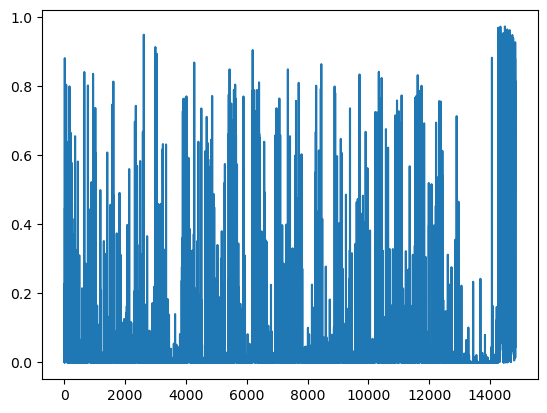

In [59]:
plt.plot(Y_pred)

In [21]:
filename_valid_lead2 = sorted(glob("/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3_temp/VALID*lead2.npy"))

In [22]:
len(filename_valid_lead2)

354468

In [23]:
len(filename_valid_lead2)/40000

8.8617

In [24]:
filename_xxx_lead2 = sorted(glob("/glade/campaign/cisl/aiml/ksha/NCAR_batch_v4_temp/*TEST*lead2.npy"))

In [25]:
len(filename_xxx_lead2)/40000

11.9355

In [ ]:
# training parameters
epochs = 500
L_train = 64
min_del = 0.0
max_tol = 100 # early stopping with patience
batch_size = 200

# Allocate batch files
X_batch_64 = np.empty((batch_size, 64, 64, L_vars))
Y_batch = np.empty((batch_size, 1))
X_batch_64[...] = np.nan
Y_batch[...] = np.nan

# Model check-point info
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'
model_name = model_prefix_save
model_path = temp_dir + model_name

# ========== Training loop ========== #
tol = 0 # initial tol

filename_pos_train = pos_train_all
filename_neg_train = neg_train_all
L_pos = len(filename_pos_train)
L_neg = len(filename_neg_train)

record = record_temp
print("Initial record: {}".format(record))

mu.set_seeds(seeds)
    
for i in range(epochs):
    start_time = time.time()

    # loop of batch
    for j in range(L_train):
        N_pos = 20
        N_neg = batch_size - N_pos

        ind_neg = du.shuffle_ind(L_neg)
        ind_pos = du.shuffle_ind(L_pos)
        
        # neg batches from this training rotation 
        file_pick_neg = []
        file_label_neg = []
        for ind_temp in ind_neg[:N_neg]:
            file_pick_neg.append(filename_neg_train[ind_temp])
            file_label_neg.append(y_neg_train_all_adjust[ind_temp])
            
        # pos batches from this training rotation 
        file_pick_pos = []
        file_label_pos = []
        for ind_temp in ind_pos[:N_pos]:
            file_pick_pos.append(filename_pos_train[ind_temp])
            file_label_pos.append(y_pos_train_all_adjust[ind_temp])
            
        # get all the batch filenames for checking labels
        file_pick = file_pick_neg + file_pick_pos
        file_label = file_label_neg + file_label_pos
        Y_batch = np.array(file_label)[:, None]
        
#         if len(file_pick) != batch_size:
#             sregwet # number of available files = batch size

        # Assign labels based on batch filenames
        for k in range(batch_size):
            data = np.load(file_pick[k])
            for l, c in enumerate(ind_pick_from_batch):
                temp = data[..., c] 
                X_batch_64[k, ..., l] = temp

#             if 'pos' in file_pick[k]:
#                 Y_batch[k, :] = 1.0 #np.random.uniform(0.9, 0.99)
#             elif 'neg_neg_neg' in file_pick[k]:
#                 Y_batch[k, :] = 0.0 #np.random.uniform(0.01, 0.05)
#             else:
#                 werhgaer
        # ------------------------------------------------- #
        # batch input and label from this training rotation 
        ind_ = du.shuffle_ind(batch_size)
        X_batch_64 = X_batch_64[ind_, ...]
        Y_batch = Y_batch[ind_, :]

        # train on batch
        model_final.train_on_batch(X_batch_64, Y_batch);

    # epoch end operations
    Y_pred = model_final.predict([VALID_input_64])
    record_temp = mu.verif_metric(VALID_target, Y_pred)

    if (record - record_temp > min_del):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        print('save to: {}'.format(model_path))
        model_final.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        if record_temp >= 2.0:
            print('Early stopping')
            break;
        else:
            tol += 1
            if tol >= max_tol:
                print('Early stopping')
                break;
            else:
                continue;
    print("--- %s seconds ---" % (time.time() - start_time))

Initial record: 0.029937088896461784
0.030178929870435862
Validation loss 0.030178929870435862 NOT improved
0.03000514702601559
Validation loss 0.03000514702601559 NOT improved
0.0300116650587397
Validation loss 0.0300116650587397 NOT improved
0.03013433066604859
Validation loss 0.03013433066604859 NOT improved
0.030309813078972375
Validation loss 0.030309813078972375 NOT improved
0.030128384079126356
Validation loss 0.030128384079126356 NOT improved
0.030543735214259495
Validation loss 0.030543735214259495 NOT improved
0.03036427530539689
Validation loss 0.03036427530539689 NOT improved
0.030175015778149853
Validation loss 0.030175015778149853 NOT improved
0.030463259133061128
Validation loss 0.030463259133061128 NOT improved
0.030186379570086394
Validation loss 0.030186379570086394 NOT improved


In [ ]:
Y_batch.shape